# Survey Data Cleaning & Visualization

This notebook is dedicated to a short visual exploration of a survey data. The survey participants are students in a graduate program. The survey includes 13 questions related to data science skills and experiences, as well as some personal questions to get to know your class better. As part of the survey, each student answered 13 questions and also predicted how the fellow students would answer each question. For example, there is a question around food preferences and whether one prefers spicy, sweet or savory food. Each student would select the preferred type of food, for example, savory. Next, each student can predict what percentage of the class prefers savory, sweet, or spicy foods. For example, one could predict 20%, 30%, and 50% split between savory, sweet, and spicy foods. The full dataset is available on GitHub https://github.com/tsolopchuk/survey_visualization

The main objective of this notebook is to provide a better understanding of the collected survey data. For example, explore how the predictions differ from actual responses, or if there is a correlation between how people answered different questions. In order to achieve these objectives, we are going to do some visual exploration of data. However, before we can get started with the data visualization, we need to clean up our dataset.

# Load and clean the data 
Below is a snapshot of the messy survey data. Responses of one student is aggregated into one row. The below snapshot includes responses of one participant and as we can notice the questions are mixed in with the answers, predictions are mixed in with student's actual responses. Additionally, the survey questions have different number of responses. For example, 'Have you ever visited NYC?' question has two answers: 'Yes' and 'No', while 'Which generation do you most identify with?' has five possible answers.

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
from pywaffle import Waffle
from textwrap import wrap

df = pd.read_csv('Combine_Corrected_Survey.csv')
print(df.iloc[0,:])

username                                                                                                                                                                                                    student1
How comfortable are you with your ability to debug an error in a python script?                                                                                    Comfortable  : 64;Neither comfortable nor unco...
Doing well at programming tasks will enhance my career/job opportunities.                                                                                          Agree: 46;Disagree: 13;Neither agree nor disag...
How comfortable are you with your ability to perform data visualization with python?                                                                               Comfortable: 42;Neither comfortable nor uncomf...
Doing well at data visualization will enhance my career/job opportunities.                                                                          

First, we are going to define a function that cleans the survey data. This function allows to clean all 13 questions, regardless of structure of each question. The function takes the actual question and associated data for that question as an input. The function provides clean predicted values dataframe and clean actual values dataframe as an output.

In [10]:
#the below function cleans the dataset and returns predicted values, survey question, and actual values as an output 
def cleanser(col1, question):

    list1 = []
    list2 = []
    list3 = []
    list4 = []
    list5 = []
    answer = []
    
    #first, the function checks how many answers are in each question. For example, most of the questions have 3 answers,
    #but there are a few questions that have a different number of answer (for example, Yes/No)
    reg_label = re.findall('[a-zA-Z][^:]+',col1.iloc[0])
    if len(reg_label) == 4:     
        #using regex find column labels (e.g., Agree/ Disagree) and create an 'answer' list with actual values 
        for i in col1:
            reg_label = re.findall('[a-zA-Z][^:]+',i)
            label1 = reg_label[0].strip()
            label2 = reg_label[1].strip()
            label3 = reg_label[2].strip()
            answer.append(reg_label[3])
            
            #using regex find predicted values and append to corresponding lists 
            reg = re.findall('[0-9]+',i)
            list1.append(int(reg[0]))
            list2.append(int(reg[1]))
            list3.append(int(reg[2]))

        #create dataframe from 3 lists with predicted values and add identified labels; returns predicted values df for a question 
        df_col1 = pd.DataFrame([list1, list2, list3])
        df_col1.columns = df['username']
        df_col1.index = [label1, label2, label3]
        df_col1 = df_col1.T

    elif len(reg_label) == 3: 
        for i in col1:
            reg_label = re.findall('[a-zA-Z][^:]+',i)
            label1 = reg_label[0].strip()
            label2 = reg_label[1].strip()
            answer.append(reg_label[2])

            reg = re.findall('[0-9]+',i)
            list1.append(int(reg[0]))
            list2.append(int(reg[1]))

        df_col1 = pd.DataFrame([list1, list2])
        df_col1.columns = df['username']
        df_col1.index = [label1, label2]
        df_col1 = df_col1.T

    elif len(reg_label) == 6:
        for i in col1:
            reg_label = re.findall('[a-zA-Z][^:]+',i)
            label1 = reg_label[0].strip()
            label2 = reg_label[1].strip()
            label3 = reg_label[2].strip()
            label4 = reg_label[3].strip()
            label5 = reg_label[4].strip()
            answer.append(reg_label[5])

            reg = re.findall('[0-9]+',i)
            list1.append(int(reg[0]))
            list2.append(int(reg[1]))
            list3.append(int(reg[2]))
            list4.append(int(reg[3]))
            list5.append(int(reg[4]))

        df_col1 = pd.DataFrame([list1, list2, list3, list4, list5])
        df_col1.columns = df['username']
        df_col1.index = [label1, label2, label3, label4, label5]
        df_col1 = df_col1.T
        
    return df_col1, answer, question


Below is a snapshot of cleaned data for one of the survey questions.

In [11]:
#Now we can use the above defined function to test how it loads and cleans the data
func = cleanser(df.iloc[:,1], df.columns[1])

#the function returns a tuple, so we will need to unpack it
df_pred, answer, question = func
print(df_pred.head(3))
print(df_pred.columns)
print(question)

          Comfortable  Neither comfortable nor uncomfortable  Uncomfortable
username                                                                   
student1           64                                     27              9
student2            0                                     30             70
student3           10                                     50             40
Index(['Comfortable', 'Neither comfortable nor uncomfortable',
       'Uncomfortable'],
      dtype='object')
How comfortable are you with your ability to debug an error in a python script?


# Initial data exploration with barcharts and pieplots 
Let's say we wanted to take a look at the overall pattern in predicted and actual values. For example, how many students predicted that their peers are comfortable debugging the code ('How comfortable are you with your ability to debug an error in a python script?'). For the below section I am using the first 6 questions to analyze data science and career specific questions.

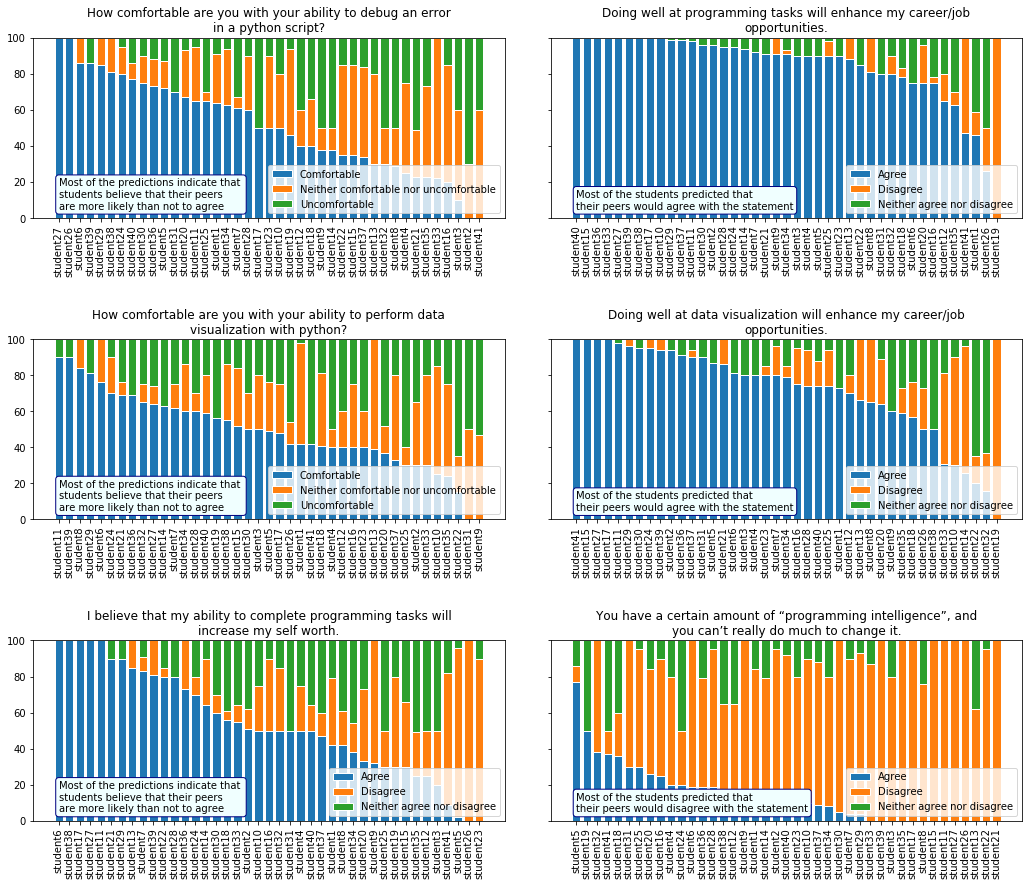

In [19]:
#The below function creates a barplot. The function takes prediction df as one of the inputs.
#Text input refers to annotations that we can customize for each of the barplots 

def bar_plots(Q, question, i, j, text):
    
    Q = Q.sort_values(by = Q.columns[0], ascending = False)

    bars1 = (Q.iloc[:,0])
    bars2 = (Q.iloc[:,1])
    bars3 = (Q.iloc[:,2])
    bars = np.add(bars1, bars2).tolist()
    names = Q.index

    ax[i,j].bar(names, bars1, edgecolor='white', label=Q.columns[0])
    ax[i,j].bar(names, bars2, bottom=bars1, edgecolor='white', label=Q.columns[1])
    ax[i,j].bar(names, bars3, bottom=bars, edgecolor='white',label=Q.columns[2])
    ax[i,j].annotate(text, xy=(0,5), size=10, 
                 bbox=dict(boxstyle='round, pad=0.3', fc='azure',ec='navy',lw=1))
    #I am using wrap function so that the title is displayed in two lines and it is more legible
    ax[i,j].set_title("\n".join(wrap(question, 60)))
    ax[i,j].set_xticklabels(names, rotation=90, size=10);
    ax[i,j].legend(loc='lower right')
    
#Below are the annotations for each of the 6 plots 
annotation_1= 'Most of the predictions indicate that \nstudents believe that their peers \nare more likely than not to agree'
annotation_2 = 'Most of the students predicted that \ntheir peers would agree with the statement'
annotation_3 = 'Most of the predictions indicate that \nstudents believe that their peers \nare more likely than not to agree'
annotation_4 = 'Most of the students predicted that \ntheir peers would agree with the statement'
annotation_5 = 'Most of the predictions indicate that \nstudents believe that their peers \nare more likely than not to agree'
annotation_6= 'Most of the students predicted that \ntheir peers would disagree with the statement'

#we are putting annotations in a list, so we can use them in the bar_plots function we defined above 
l = [0, annotation_1, annotation_2, annotation_3, annotation_4, annotation_5, annotation_6]

#now, we can create our figure 
#I am setting the tight_layout so there is more space between the charts and all labels are visible
fig, ax = plt.subplots(3,2, figsize = (15,12),  sharey='row')
fig.tight_layout(pad=3.0, h_pad=10.0)

#Using the for loops we can fill our figure using bar_plots function and loading the data using cleanser function defined earlier
n=0
for i in range(3):
        for j in range(2):
            n+=1
            Q_data_load = cleanser(df.iloc[:,n], df.columns[n])
            Q_data,  answer, question = Q_data_load
            bar_plots(Q_data, question, i,j, l[n])

The above stacked barplots show the predicted responses. We can look at the actual responses by using pie charts. First, we will need to load the actual responses using the earlier defined cleanser function. 

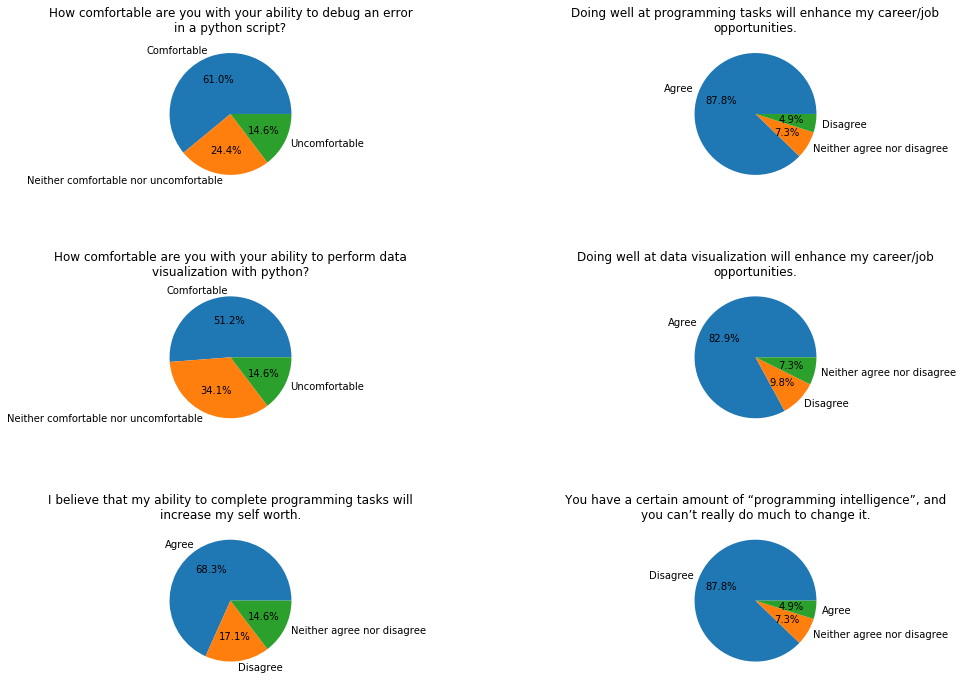

In [15]:
#As a first step, let's first create one df that will contain all actual answers for 6 questions. 
l = []
questions = []
n=0
while n <6:
    n+=1
    Q_data_load = cleanser(df.iloc[:,n], df.columns[n])
    *_, Q, ques = Q_data_load
    l.append(Q)
    questions.append(ques)

actual_values = pd.DataFrame(l)
actual_values = actual_values.T
labels = ['Q1', 'Q2', 'Q3' ,'Q4', 'Q5', 'Q6']
actual_values.columns = labels
#I have noticed that there are some spaces around answers for question 1. I removed them below. 
actual_values['Q1'] = actual_values['Q1'].str.strip()


#Below we are creating a function that builds a pie chart based on the actual values df defined above
def pies(t, i, j):
    data = actual_values.iloc[:,t].value_counts()
    ax[i,j].pie(data, labels= data.index, autopct='%1.1f%%')
    ax[i,j].set_title("\n".join(wrap(questions[t], 60)))

#Now, we can create a figure and fill it in using for loops
fig, ax = plt.subplots(3,2, figsize = (15,10))
fig.tight_layout(pad=3.0, h_pad=7.0)

t=-1
for i in range(3):
    for j in range(2):
        t+=1
        pies(t,i,j)

Some initial insights from the explored data are presented below.
It seems that more people disagree that a certain level of programming intelligence is something that cannot be changed. Also, most of the class agrees that doing well at programming and visualization tasks will enhance possible career opportunities.
More than half of the respondents are also comfortable performing data visualization in Python and are confident in their ability to debug the code.
It was interesting to learn that 68% of the respondents believe that completing programming tasks increases their self-worth.

# Compare predicted values to actual values
In the next section we will use the predicted and actual values on the same plot to see how far off the actual values were from the predicted values.
The scatterplot represents predicted values and the dashed lines represent actual values.

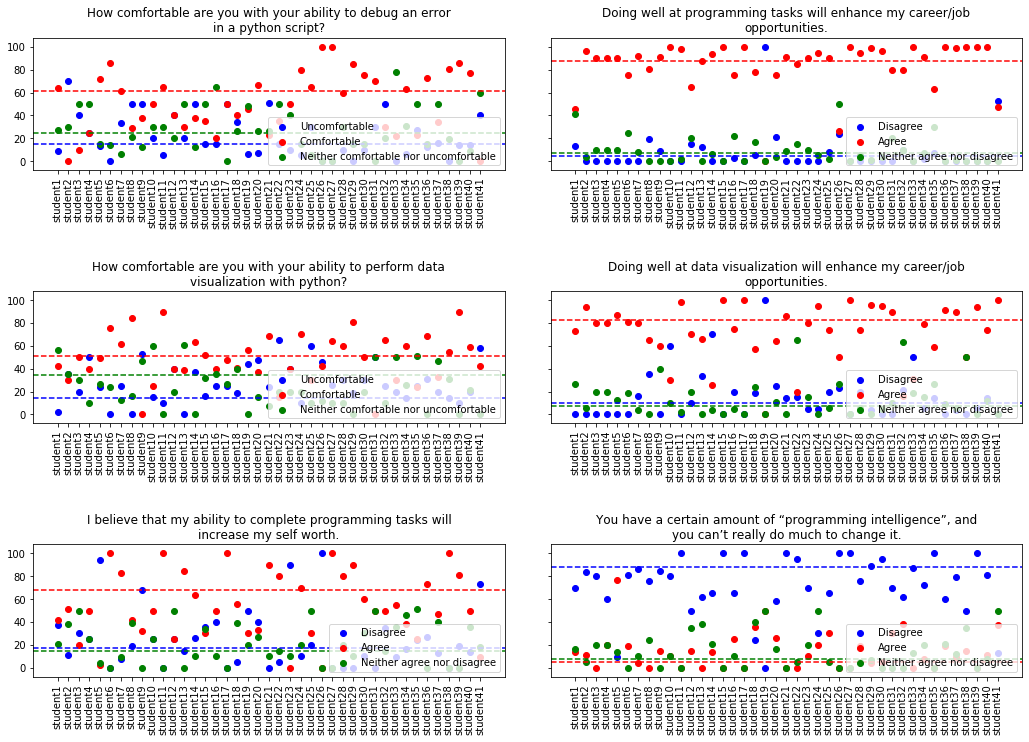

In [18]:
#first let's define a function that create a scatterplot of predicted values and draws a straight line with actual values

def scatter_plots(df_pred, question, i, j , q):
    names = (df_pred.index)
    #we have two different types of answers (Agree/Disagree) and (Comfortable/Uncomfortable), 
    #so we check which column names are applicable for each of the charts 
    if list(df_pred.columns) == ['Agree', 'Disagree', 'Neither agree nor disagree']:
        
        #to be able to compare actual values to predicted, we need to count the actual results and convert result to percentage
        count_actual = actual_values.iloc[:,q].value_counts()
        actual1 = count_actual['Disagree']/41*100
        actual2 = count_actual['Agree']/41*100
        actual3 = count_actual['Neither agree nor disagree']/41*100
        
        #scatter plot will represent predicted values 
        ax[i,j].scatter(names, df_pred['Disagree'], color='blue', label = df_pred['Disagree'].name)
        ax[i,j].scatter(names, df_pred['Agree'], color='red', label = df_pred['Agree'].name)
        ax[i,j].scatter(names, df_pred['Neither agree nor disagree'], color='green', 
                        label=df_pred['Neither agree nor disagree'].name)
        #axhline will represent calculated actual percentages 
        ax[i,j].axhline(actual1, color='blue', linestyle = 'dashed')
        ax[i,j].axhline(actual2, color = 'red', linestyle = 'dashed')
        ax[i,j].axhline(actual3, color = 'green', linestyle = 'dashed')

        ax[i,j].set_title("\n".join(wrap(question, 60)))
        ax[i,j].legend(loc='lower right')
        ax[i,j].set_xticklabels(names, rotation=90, size=10);
    
    #same process as described above applies for Comfortable/ Uncomfortable labels 
    elif list(df_pred.columns) == ['Comfortable', 'Neither comfortable nor uncomfortable',
       'Uncomfortable']:
    
        count_actual = actual_values.iloc[:,q].value_counts()
        actual1 = count_actual['Uncomfortable']/41*100
        actual2 = count_actual['Comfortable']/41*100
        actual3 = count_actual['Neither comfortable nor uncomfortable']/41*100

        ax[i,j].scatter(names, df_pred['Uncomfortable'], color='blue' , label = df_pred['Uncomfortable'].name)
        ax[i,j].scatter(names, df_pred['Comfortable'], color='red', label = df_pred['Comfortable'].name)
        ax[i,j].scatter(names, df_pred['Neither comfortable nor uncomfortable'], color='green', 
                        label=df_pred['Neither comfortable nor uncomfortable'].name)
        ax[i,j].axhline(actual1, color='blue', linestyle = 'dashed')
        ax[i,j].axhline(actual2, color = 'red', linestyle = 'dashed')
        ax[i,j].axhline(actual3, color = 'green', linestyle = 'dashed')

        
        ax[i,j].set_title("\n".join(wrap(question, 60)))       
        ax[i,j].legend(loc='lower right')
        ax[i,j].set_xticklabels(names, rotation=90, size=10);
    
#creating a figure and filling it in using for loops
fig, ax = plt.subplots(3,2, figsize = (15,10),  sharey='row')
fig.tight_layout(pad=3.0, h_pad=10.0)

n=0
q=-1
for i in range(3):
        for j in range(2):
            n+=1
            q+=1
            Q_data_load = cleanser(df.iloc[:,n], df.columns[n])
            Q_data, answer, question = Q_data_load
            scatter_plots(Q_data, question, i,j,q)

I was also a participant in this survey as well! So I found my responses on the charts above, since I was curious how well I did in predicting responses of other students. And I came close in predicting only 2 out of 6 questions (oh no!). My only close predictions were that I thought the rest of the class will agree that doing programming and visualization tasks will improve career opportunities. The rest I missed by a lot...

However, it is also interesting to see how close the class was to predict actual values as a group. It seems that the class was better at predicting programming intelligence question and that doing programming and visualization tasks will improve career outcomes. The collective ability to estimate peers' skills was not as precise when compared to actual results.

# Is there correlation between predicted answers? 
Next, we can create a heatmap and explore correlation between different answers for the six questions we have been working with. For example, is there a correlation between disagreeing with question 1 and agreeing with question 6?  

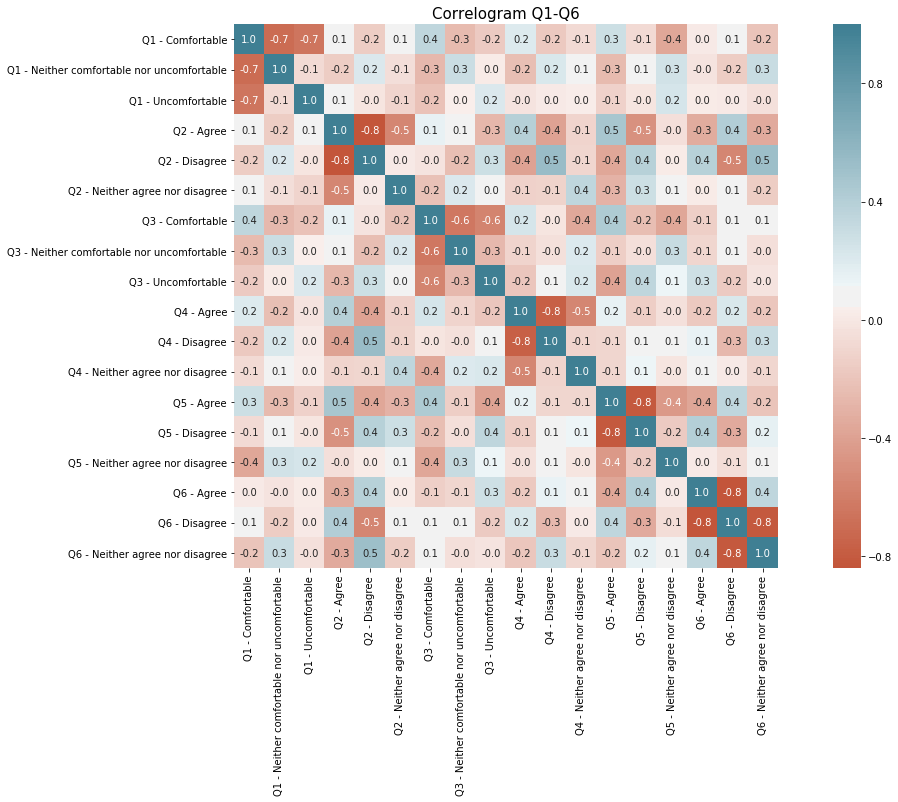

In [17]:
#Below we are calling the cleanser function defined in the first cell of this notebook.
#we also going to apply some minor data manipulations to add question number (e.g., Q1) to the column labels, so we can
#get something like 'Q1 - Disagree'. This will allow us to easier interpret the heatmap 
func = cleanser(df.iloc[:,1], df.columns[1])
df_pred_Q1, answer_Q1, question_Q1 = func
df_pred_Q1.columns = 'Q1 - ' + df_pred_Q1.columns 
df_pred_Q1 = df_pred_Q1.reset_index()
df_pred_Q1.drop(columns = [ 'username'], inplace=True)

func = cleanser(df.iloc[:,2], df.columns[2])
df_pred_Q2, answer_Q2, question_Q2 = func
df_pred_Q2.columns = 'Q2 - ' + df_pred_Q2.columns 
df_pred_Q2 = df_pred_Q2.reset_index()
df_pred_Q2.drop(columns = [ 'username'], inplace=True)

func = cleanser(df.iloc[:,3], df.columns[3])
df_pred_Q3, answer_Q3, question_Q3 = func
df_pred_Q3.columns = 'Q3 - ' + df_pred_Q3.columns 
df_pred_Q3 = df_pred_Q3.reset_index()
df_pred_Q3.drop(columns = [ 'username'], inplace=True)

func = cleanser(df.iloc[:,4], df.columns[4])
df_pred_Q4, answer_Q4, question_Q4 = func
df_pred_Q4.columns = 'Q4 - ' + df_pred_Q4.columns 
df_pred_Q4 = df_pred_Q4.reset_index()
df_pred_Q4.drop(columns = [ 'username'], inplace=True)

func = cleanser(df.iloc[:,5], df.columns[5])
df_pred_Q5, answer_Q5, question_Q5 = func
df_pred_Q5.columns = 'Q5 - ' + df_pred_Q5.columns 
df_pred_Q5 = df_pred_Q5.reset_index()
df_pred_Q5.drop(columns = [ 'username'], inplace=True)

func = cleanser(df.iloc[:,6], df.columns[6])
df_pred_Q6, answer_Q6, question_Q6 = func
df_pred_Q6.columns = 'Q6 - ' + df_pred_Q6.columns 
df_pred_Q6 = df_pred_Q6.reset_index()
df_pred_Q6.drop(columns = [ 'username'], inplace=True)

df_preds = pd.concat([df_pred_Q1, df_pred_Q2, df_pred_Q3, df_pred_Q4, df_pred_Q5, df_pred_Q6], sort =False, axis=1)

df_pred_Q1['question']= 'Q1'
df_pred_Q1['question']= 'Q1'
df_pred_Q3['question']= 'Q3'
df_pred_Q4['question']= 'Q4'
df_pred_Q5['question']= 'Q5'
df_pred_Q6['question']= 'Q6'

#Below we are creating a heatmap, we are also going to include correlation coefficients in each cell so it is easier to
#interpret the results 
corr = df_preds.corr()
plt.figure(figsize=(20,10))
ax=sns.heatmap(
    corr, annot= True, fmt='.1f', square= True,
    cmap=sns.diverging_palette(20, 220, n=200))
ax.set_title('Correlogram Q1-Q6', size = 15)
bottom, top = ax.get_ylim()

#there is actually a bug in the latest version of matplotlib that cuts the top row of heat map in half. 
#I found the below fix online
ax.set_ylim(bottom + 0.5, top - 0.5);


We can clearly see that there is a strong correlation between predicting 'Disagree' and 'Agree' within the same question. This makes intuitive sense. For example, if someone predicts that class will 'Disagree' with the statement, then they are also very likely to predict that the class will not 'Agree' with the same statement. We will see high negative correlations for such examples. For example, ‘Disagree’ with Question 6 has high negative correlation with ‘Agree’ with Question 6. This is quite straightforward.

However, if we compare answers between different questions, we can see that certain answers have moderate correlation. For example, there is a moderate correlation between 'Agree' answer in Q2 and ‘Agree’ answer in Q5. The correlation coefficient is about 0.5, which could be considered as moderate correlation. We could say that if someone agreed with Q2 ('Doing well at programming tasks will enhance my career/job opportunities.') they are also likely going to agree with Q5 ('I believe that my ability to complete programming tasks will increase my self worth.').

# Get to know your class!
The first part of this notebook was focused on the first 6 career and data science knowledge questions. However, I also wanted to take a look at some more fun personal questions, for example, what percentage of the class has been to NYC and what percentage of the class likes spicy food!

The first plot that I am using in this section is stripplot. The stripplot scatter will show predicted values and the pointplot will show actual values. I am using seaborn library for this next section, as I wanted to explore additional libraries besides matplotlib.pyplot.

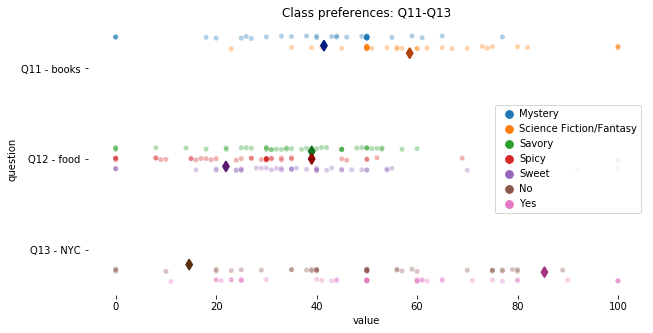

In [7]:
#load predicted values for Questions 10-13
func = cleanser(df.iloc[:,10], df.columns[10])
df_pred_Q10, answer_Q10, question_Q10 = func
df_pred_Q10 = df_pred_Q10.reset_index()
df_pred_Q10.drop(columns = [ 'username'], inplace=True)

func = cleanser(df.iloc[:,11], df.columns[11])
df_pred_Q11, answer_Q11, question_Q11 = func
df_pred_Q11 = df_pred_Q11.reset_index()
df_pred_Q11.drop(columns = [ 'username'], inplace=True)

func = cleanser(df.iloc[:,12], df.columns[12])
df_pred_Q12, answer_Q12, question_Q12 = func
df_pred_Q12 = df_pred_Q12.reset_index()
df_pred_Q12.drop(columns = [ 'username'], inplace=True)

func = cleanser(df.iloc[:,13], df.columns[13])
df_pred_Q13, answer_Q13, question_Q13 = func
df_pred_Q13 = df_pred_Q13.reset_index()
df_pred_Q13.drop(columns = [ 'username'], inplace=True)

df_pred_Q10['question']= 'Q10'
df_pred_Q11['question']= 'Q11'
df_pred_Q12['question']= 'Q12'
df_pred_Q13['question']= 'Q13'

#create actuals df 
actual_values = pd.DataFrame([answer_Q11, answer_Q12, answer_Q13])

actual_values = actual_values.T
labels = [ 'Q11 - books', 'Q12 - food' ,'Q13 - NYC']
actual_values.columns = labels

df_pred = pd.concat([df_pred_Q11, df_pred_Q12, df_pred_Q13],sort = False)

#melt the data into format needed for the charts 
pred = pd.melt(df_pred,'question', var_name = 'response')
act = pd.melt(actual_values, var_name = 'response')

act_group = act.groupby(['response', 'value']).size()
act_group = pd.DataFrame(act_group)
act_group = act_group.reset_index()
act_group.columns = ['question','response','value']
act_group['value'] = act_group['value']/41*100


#create stripplots using predicted values and pointplots using actual values 
fig, ax = plt.subplots(figsize = (10,5))
sns.despine(bottom=True, left=True)

sns.stripplot(x="value", y="question", hue="response",
                  data=pred, dodge=True, alpha=.35, zorder=1)

sns.pointplot(x="value", y="question", hue="response",
                  data=act_group, dodge=.5, join=False, palette="dark",
                  markers="d", scale=1)
ax.set_title('Class preferences: Q11-Q13', size =12)

#clean up the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:7], labels[:7],
handletextpad=0, columnspacing=1,
loc="center right", ncol=1, frameon=True);

The scatter above shows the predicted values and the poinplots show the actual values.

It seems that most of the class (about 60%) likes science fiction and fantasy books! Also, most of the class (about 85%) have been to NYC. Only about 20% of the class prefers sweet food.

We can also see that the class as a group underpredicted how many people have been to NYC and overpredicted how many people actually like sweet food!

We can also create a fun pictogram showing individual preferences. The below plot is created using an interesting library called PyWaffle. I included link to the documentation and GitHub project below. I have encountered pictograms used extensively in infographics and also in executive summary presentations, so this could be a quite helpful view in certain situations.

Below I am plotting the actual % of class that like specific type of books, food.

https://readthedocs.org/projects/pywaffle/downloads/pdf/latest/
https://github.com/gyli/PyWaffle/blob/master/pywaffle/fontawesome_mapping.py

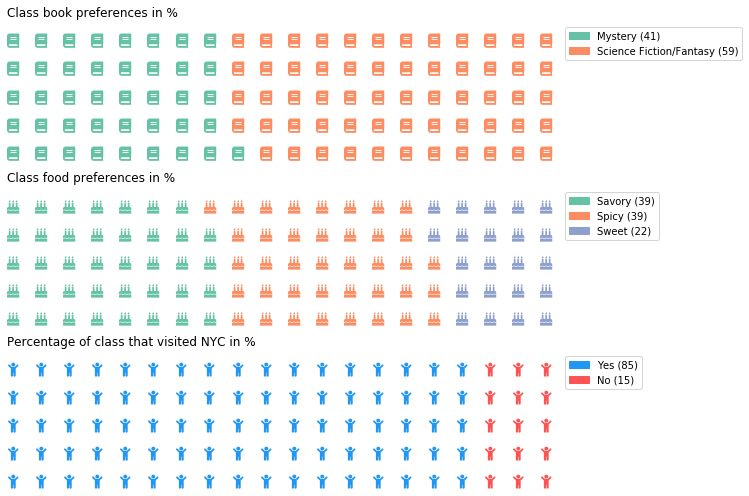

In [8]:
#we just need high level summary of actual answers 
books = {'Mystery': 41, 'Science Fiction/Fantasy': 59}
food = {'Savory': 39, 'Spicy': 39, 'Sweet':22}
nyc = {'Yes': 85, 'No':15}


fig = plt.figure(
    FigureClass=Waffle,
    plots={
        '311': {
            'values': books,
            'icons':'book',
            'labels': [f"{a} ({b})" for a,b in books.items()],
            'legend': {
                'loc': 'upper right',
                'bbox_to_anchor': (1.33, 1),
                'fontsize': 10
            },
            'title': {
                'label': 'Class book preferences in %',
                'loc': 'left',
                'fontsize' : 12
            }
        },
        '312': {
            'values': food ,
            'labels': [f"{a} ({b})" for a,b in food.items()],
            'icons' : 'birthday-cake',
            'legend': {
                'loc': 'upper right',
                'bbox_to_anchor': (1.18, 1),
                'fontsize': 10
            },
            'title': {
                'label': 'Class food preferences in %',
                'loc': 'left',
                'fontsize' : 12
            }
        },
        '313': {
            'values': nyc ,
            'colors': ("#2196f3", "#ff5252"),
            'icons' : 'child',
            'labels': [f"{a} ({b})" for a,b in nyc.items()],
            'legend': {
                'loc': 'upper right',
                'bbox_to_anchor': (1.15, 1),
                'fontsize': 10
            },
            'title': {
                'label': 'Percentage of class that visited NYC in %',
                'loc': 'left',
                'fontsize' : 12
            }
        },
    },
    rows=5,
    figsize=(10, 7)  
)
                

This is a different way to present an actual result of the survey for some of the personal questions. I used pie charts for the same purpose on the first 6 questions of the survey, but pictogram is another fun way to look at the actual results!